In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import timeit

class Graph:
    __slots__ = ["adjacency_matrix", "n", "m", "k"]

    def __init__(self, n, m, k):
        self.n = n
        self.m = m
        self.k = k
        self.adjacency_matrix = [[False] * n for _ in range(n)]
    
    @classmethod
    def from_file(cls, file_name):
        '''Loads a graph from a file'''
        with open(file_name, 'r') as f:
            # extract graph parameters
            m, n, k = map(int, f.readline().split())
            # call graph class constructor
            graph = cls(n, m, k)
            # skip whitespaces
            lines = [line for line in f if not line.isspace()]
            for line in lines:
                # add edges
                u, v = map(int, line.split())
                graph.add_edge(u-1, v-1)
        return graph
    
    def add_edge(self, u, v):
        '''Creates an edge between vertex u and vertex v on the adjacency matrix'''
        self.adjacency_matrix[u][v] = True
        self.adjacency_matrix[v][u] = True
    
    def draw_graph(self, nodes_to_highlight):
        '''Draws the graph'''
        # Create graph from adjacency matrix
        G = nx.from_numpy_matrix(np.array(self.adjacency_matrix))

        # Set node position using Fruchterman-Reingold layout algorithm
        pos = nx.spring_layout(G)

        # Draw the graph
        fig, ax = plt.subplots(figsize=(10, 8))

        # Remap nodes to match input names
        labels = {node: str(node + 1) for node in G.nodes()}

        # # Set color map
        # node_colors = ['yellow' if nodes_to_highlight and nodes_to_highlight[i] else 'lightblue' for i in range(len(G.nodes()))]

        # Draw nodes with circles
        nx.draw_networkx_nodes(G, pos=pos, node_size=0, ax=ax)
        nodes = nx.draw_networkx_labels(G, pos=pos, labels=labels, font_size=10, font_color='black', ax=ax)

        # Add circles around nodes
        
        for index, node_patch in nodes.items():
            node_patch.set_bbox(dict(boxstyle="circle,pad=0.3", fc="white", ec="black", lw=2))
            if nodes_to_highlight[index]:
                node_patch.set_bbox(dict(boxstyle="circle,pad=0.3", fc="yellow", ec="black", lw=2))

        # Draw edges
        nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color='black')

        result_title = "possible" if any(nodes_to_highlight) > 0 else "not possible"
        plt.title(result_title)

        # Show plot
        plt.show()

    def validate_and_show_bins(self, algorithm):
        print(f"Result via '{algorithm.__name__}':")
        result = algorithm(self)
        independent_set = [] if result is None else result
        vertex_colors = [i in independent_set for i in range(graph.n)]
        self.draw_graph(vertex_colors)
        


In [3]:
def greedy(graph):
    # Target independent set
    independent_set = set()
    # Candidate vertices
    candidate_vertices = set(range(graph.n))
    # Continue adding vertices until size k is reached or no candidates remain
    while len(independent_set) < graph.k and len(candidate_vertices) > 0:
        # Select vertex with most connections
        v = max(candidate_vertices, key=lambda x: sum(graph.adjacency_matrix[x][y] for y in independent_set))
        # Check if the selected vertex is non-adjacent to all vertices in the independent set
        if sum(graph.adjacency_matrix[v][w] for w in independent_set) == 0:
            # Add to independent set
            independent_set.add(v)
        # Remove from candidates
        candidate_vertices.remove(v)
    # Check if the independent set has the desired size
    if len(independent_set) == graph.k:
        return independent_set
    else:
        return None


In [4]:
import itertools

def exhaustive(graph):
    n = len(graph.adjacency_matrix)
    for combination in itertools.combinations(range(n), graph.k):
        if all(graph.adjacency_matrix[i][j] == 0 for i, j in itertools.combinations(combination, 2)):
            return combination
    return None

In [5]:
def backtracking(graph):
    adjMatrix = graph.adjacency_matrix
    k = graph.k
    n = len(adjMatrix)
    current_set = []  # initialize an empty list to store the current candidate set
    
    def is_valid_candidate(candidate):
        # check if a candidate set is valid by ensuring that there are no edges
        # between nodes in the set (except for self-loops)
        return all(not adjMatrix[node][other] for node in candidate for other in candidate if other != node)
    
    def backtrack(start_node):
        nonlocal current_set
        # base case: if we have found a candidate set of size k, we are done
        if len(current_set) == k:
            return True
        # recursive case: try adding each node (starting from start_node) to the candidate set
        for node in range(start_node, n):
            # check if the node is not already in the candidate set
            if node not in current_set:
                current_set.append(node)
                # check if the current candidate set is still valid
                if is_valid_candidate(current_set):
                    # if the candidate set is still valid, try adding the next node
                    # (starting from node + 1) to the candidate set recursively
                    if backtrack(node + 1):
                        return True
                current_set.pop()  # backtrack by removing the current node from the candidate set
        return False  # backtrack by returning False to the previous call of backtrack()
    
    # try to find a candidate set starting from node 0
    if backtrack(0):
        return current_set  # if a candidate set of size k is found, return it
    else:
        return None  # otherwise, return None


Result via 'greedy':


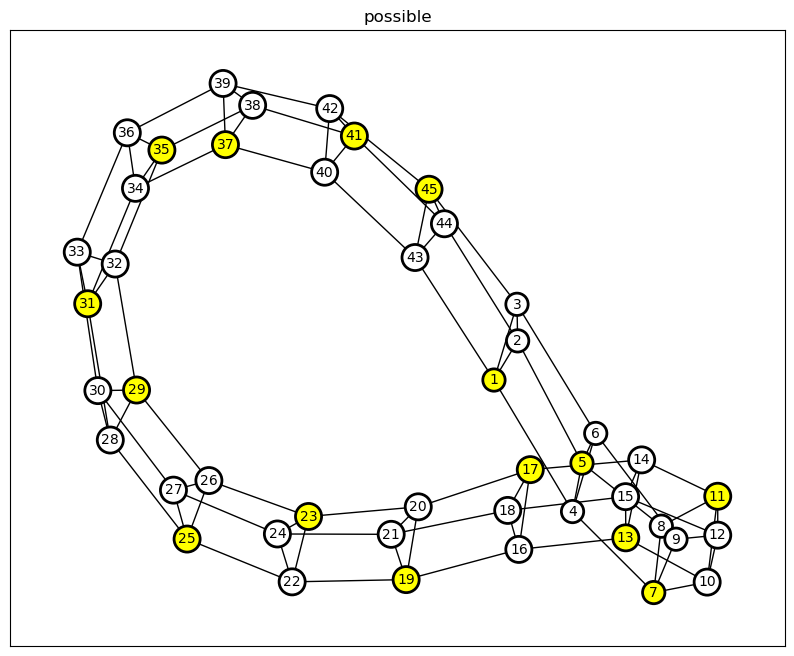

Running time: 0.244855 seconds



Result via 'backtracking':


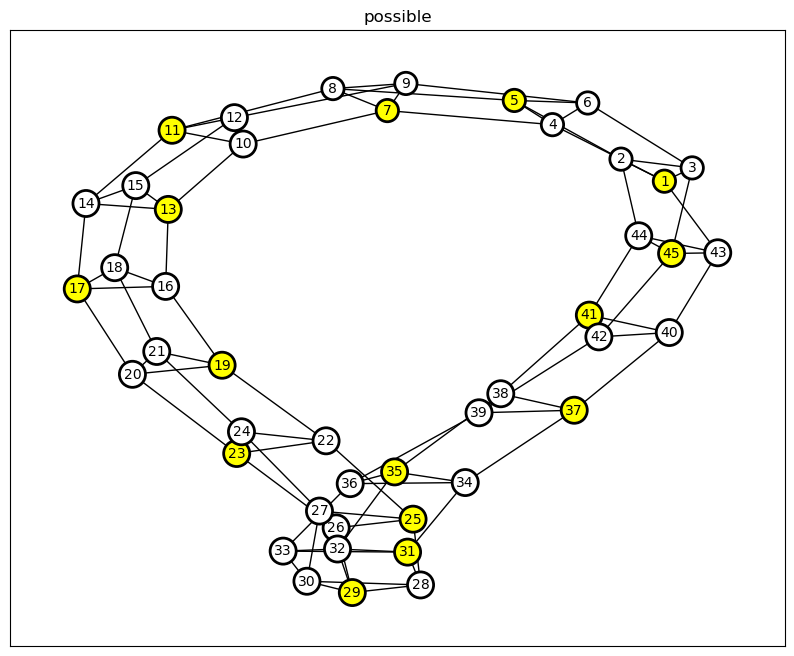

Running time: 0.213242 seconds



Result via 'exhaustive':


KeyboardInterrupt: 

In [6]:
graph = Graph.from_file('samples/big_1.in')
t1 = timeit.timeit(lambda: graph.validate_and_show_bins(greedy), number=1)
print("Running time: {:.6f} seconds".format(t1))
print("\n\n")
t3 = timeit.timeit(lambda: graph.validate_and_show_bins(backtracking), number=1)
print("Running time: {:.6f} seconds".format(t3))
print("\n\n")
t2 = timeit.timeit(lambda: graph.validate_and_show_bins(exhaustive), number=1)
print("Running time: {:.6f} seconds".format(t2))

In [7]:
import os

def test_algorithm(alg):
    directory = "samples/"

    def read_first_line(file_path):
        with open(file_path, 'r') as f:
            first_line = f.readline().strip()
        return first_line

    file_paths = sorted([(os.path.join(directory, filename),
                   os.path.join(directory, filename[:-3] + ".out"))
                  for filename in os.listdir(directory)
                  if filename.endswith(".in")], reverse=True)

    file_paths = [path for path in file_paths if path not in [("samples/big_4.in", "samples/big_4.out"), ("samples/big_6.in", "samples/big_6.out")]]

    for in_path, out_path in file_paths:
        print(f"Trying {in_path}")
        graph = Graph.from_file(in_path)
        expected = read_first_line(out_path)
        actual = "possible" if alg(graph) is not None else "impossible"
        assert actual == expected, \
            f"{alg.__name__} returned '{actual}', while '{expected}' was expected"

In [ ]:
test_algorithm(backtracking)

Trying samples/small_6.in
Trying samples/small_5.in
Trying samples/small_4.in
Trying samples/small_3.in
Trying samples/small_2.in
Trying samples/small_1.in
Trying samples/extra_8.in
Trying samples/extra_7.in
Trying samples/extra_6.in
Trying samples/extra_5.in
Trying samples/extra_4.in
Trying samples/extra_3.in
Trying samples/extra_2.in
Trying samples/extra_1.in
Trying samples/big_5.in
Trying samples/big_3.in
Trying samples/big_2.in
Trying samples/big_1.in
